# Quantum ESPRESSO XML Parser

This jupyter notebook contains a series of functions that can be used to parse information from the <code>.xml</code> file created during a Quantum ESREPSSO calculation.

The notebook is updated as needed.

## Contents

<b>1. Band Structure</b>

In [127]:
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from scipy.constants import physical_constants as PC

In [15]:
def getXml(xmlFile='pwscf.xml'):
    
    if os.path.isfile(xmlFile):
    
        tree = ET.parse(xmlFile)
        root = tree.getroot()
    
        return(root)
    
    else:
        print('Error: XML File Does not exist')
        print('Check location: {}'.format(xmlFile))
        
        return()

In [60]:
def xmlBranchSearch(root, children):

    newRoot = copy.copy(root)
    for child in children:
        newRoot = newRoot.find(child)
        
    return(newRoot)
    

## 1. Band Structure from XML file

The following code will extract the band structure from the xml file. This means that the last job performed by Quantum ESPRESSO included <code>calculation = 'bands'</code>, and provided the correct <b>k</b>-point path through the Brillouin zone. For help with this cosult the documentation at <code>/$ESPRESSO_ROOT/Doc/brillouin_zones.pdf</code>

In [51]:
# Set variables for locations of files

workPath = os.getcwd()
dataDirectory = '.'
dataFile = 'rup.xml'

# Should not need to edit this:
dataPath = os.path.join(workPath, dataDirectory, dataFile)

## Read XML File
run = getXml(dataPath)

In [130]:
# Extract information from XML File to generate arrays
'''
Everything we need should be underneath the band_structure
'''

bandStructure = ['output', 'band_structure']
bs = xmlBranchSearch(run, bandStructure)

# k-points
nkpoints = int(bs.find('nks').text)
# bands
nbandsUp = int(bs.find('nbnd_up').text)
nbandsDown = int(bs.find('nbnd_dw').text)
# Fermi level
eFermi = float(bs.find('two_fermi_energies').text.split()[0])
eFermiElectronVolt = eFermi / PC['electron volt-hartree relationship'][0]

print('Status: {} k-points found'.format(nkpoints))
print('Status: {} spin up bands found'.format(nbandsUp))
print('Status: {} spin down bands found'.format(nbandsDown))
print('Status: The Fermi level is {} eV'.format( eFermiElectronVolt))


Status: 261 k-points found
Status: 53 spin up bands found
Status: 53 spin down bands found
Status: The Fermi level is 18.998501804881418 eV


In [112]:
# Set up arrays for data

k = np.zeros(nkpoints)
bandEnergies = np.zeros([nkpoints, nbandsUp])

In [113]:
# Get k-points as path along x axis

'''
k-point coordinares are stored under the band_structure
but need to get all of them sequentially

We loop over each k_point and compute the distance between
the i and i-1 kpoint storing in the array k
'''

kPointList = ['starting_k_points']
kpl = xmlBranchSearch(bs, kPointList)

kpoint_coord = np.zeros(3)
for kpt in enumerate(kpl.iter('k_point')):
    
    if kpt[0] == 0:
        # If first k-point leave the x value as 0.
        for i in range(3):
            kpoint_coord[i] = float(kpt[1].text.split()[i])
        
    
    else:
        old_kpoint_coord = copy.copy(kpoint_coord)
        
        
        for i in range(3):
            kpoint_coord[i] = float(kpt[1].text.split()[i])           
            
        k[kpt[0]] = k[ kpt[0]-1]  + np.linalg.norm(kpoint_coord[:]  - old_kpoint_coord[:])
        
#print(k)

In [132]:
# Get band energies

'''
Band energies are stored in the xml by kpoint, this means we should
fill up the array 1 kpoint at a time. 
For each k-point the eigenvalues are stored 1:nup:1:ndwn so we have to
read the up energies first then the down energies
'''

for kpt in enumerate(bs.iter('eigenvalues')):
    epsilon = kpt[1].text.split()

    for band in enumerate(epsilon[:nbandsUp]):
        bandEnergies[kpt[0],band[0]] = float(band[1])-eFermi
        
bandEnergies /= PC['electron volt-hartree relationship'][0]

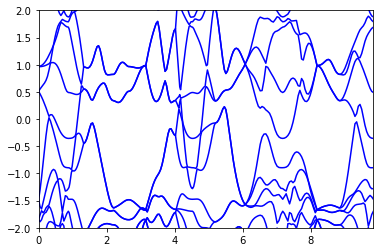

In [135]:
fig, ax = plt.subplots()

ax.set_ylim([-2,2])
ax.set_xlim([0, k[-1]])

for i in range(nbandsUp):
    ax.plot(k, bandEnergies[:,i], c='b')
    